In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Making an SED because that's my job

In [2]:
tphot = 'eg_uma_vizier_phot.vot'
c = 2.998e8*u.m/u.s



votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
wp = []
fp = []
ep = []
print(filters)

filters = ['2MASS:H', '2MASS:J', '2MASS:Ks', 'GALEX:FUV'
 ,'GALEX:NUV', 'Gaia:G', "SDSS:g'" , "SDSS:i'" , "SDSS:r'"
 , "SDSS:u'" , "SDSS:z'" ,'WISE:W1', 'WISE:W2', 'WISE:W3',
 'WISE:W4']

for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) > 0:
        if len(fj1) >1:
            fj_av = np.average(fj1, weights = (1/(e1**2)))
            e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
            e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
        else:
            fj_av, e1_av = fj1[0], e1[0]
        f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
        wp.append(w1.value)
        fp.append(f1.value)
        e1 = ((e1_av*f1)/fj_av).value
        ep.append(e1)

wp, fp, ep = np.array(wp), np.array(fp), np.array(ep)

# plt.figure(figsize=(5, 5))
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C0')
# plt.xscale('log')
# plt.yscale('log')

['2MASS:H' '2MASS:J' '2MASS:Ks' ':=3.6um' ':=5.8um' 'GALEX:FUV'
 'GALEX:NUV' 'Gaia:G' 'Johnson:B' 'Johnson:H' 'Johnson:J' 'Johnson:K'
 'Johnson:V' 'PAN-STARRS/PS1:y' 'PAN-STARRS/PS1:z' 'POSS-II:F' 'POSS-II:J'
 'POSS-II:i' 'SDSS:g' "SDSS:g'" 'SDSS:i' "SDSS:i'" 'SDSS:r' "SDSS:r'"
 'SDSS:u' "SDSS:u'" 'SDSS:z' "SDSS:z'" 'WISE:W1' 'WISE:W2' 'WISE:W3'
 'WISE:W4']


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [3]:
# cpath = '/media/david/5tb_storage1/pceb_data/eg_uma/'
cpath = '/media/david/2tb_ext_hd/hddata/eg_uma/hst/cos/'
x = glob.glob('{}*x1dsum.fits'.format(cpath))[0]

smooth=5
data = fits.getdata(x, 1)
wc = np.array([], dtype=float)
fc = np.array([], dtype=float)
ec = np.array([], dtype=float)
for dt in data[::-1]:
    wi, fi, ei, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
   # mask = (fi>0) & (dq == 0) & (wi < 1213) | (wi > 1217) & (fi>0) & (dq == 0) 
    mask = (dq==0)
    wi, fi, ei = wi[mask], fi[mask], ei[mask]
    wc = np.concatenate((wc, wi))
    fc = np.concatenate((fc, fi))
    ec = np.concatenate((ec, ei))    

fc = convolve(fc,Box1DKernel(smooth))
ec = convolve(ec,Box1DKernel(smooth))/(smooth**0.5)

# plt.plot(wc, fc)

mask = (wc < 1210) | (wc > 1220) 
wc1, fc1, ec1 = wc[mask], fc[mask], ec[mask]

In [4]:
# path = '/media/david/5tb_storage1/eg_uma/hst/stis/data/'
path = '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/'
x1ds = glob.glob('{}*x1d.fits'.format(path))

data = fits.getdata(x1ds[3])[0]
ws, fs, es = data['WAVELENGTH'], data['FLUX'], data['ERROR']

x1ds

['/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua2010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua4010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehub3010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/eg_uma/hst/stis/oehua1010_x1d.fits']

In [5]:
data = Table.read('spect.V EG UMa.Gianninas.txt', format='ascii')
# wo, fo = data['wavelength']*u.AA, data['flux']*u.mJy#u.erg/u.s/u.cm**2/u.AA
wo, fo = data['wavelength']*u.AA, data['flux']*u.J/u.s/u.cm**2/u.AA

# plt.plot(wo, fo)

In [6]:
mw, mf = np.loadtxt('scaled_eguma_model.dat', unpack=True)

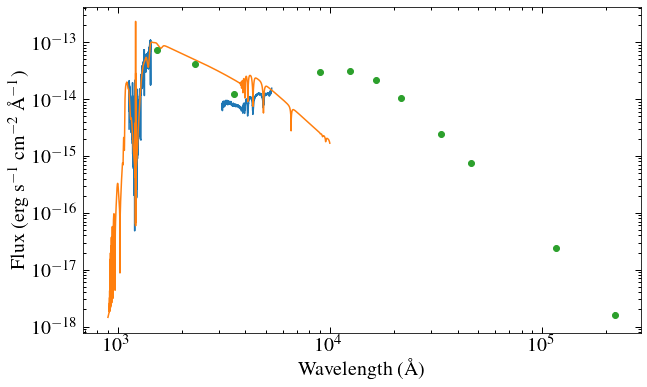

In [7]:
plt.figure(figsize=(10, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# plt.legend(frameon=True)
# plt.xlim(1140, 1420)
# plt.ylim(-0.1e-13, 1e-13)

# plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
plt.plot(wo, fo*1e11)
plt.plot(mw, mf)

# plt.xlim(1000, 2000)
plt.xscale('log')
plt.yscale('log')

(0.0, 4e-14)

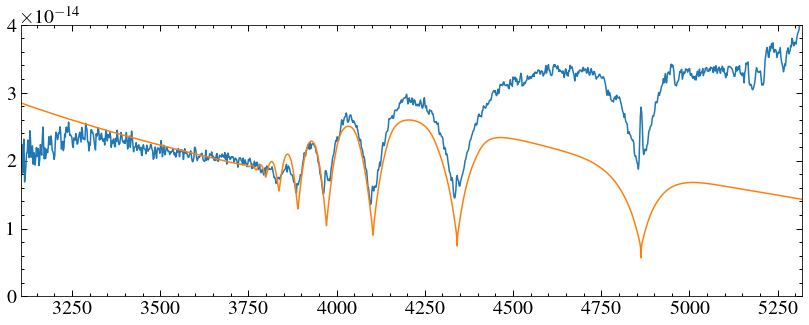

In [8]:
plt.plot(wo, fo*2.7e11)
plt.plot(mw, mf)
plt.xlim(wo[0].value, wo[-1].value)
plt.ylim(0, 0.4e-13)

adding gj1132 to compare

In [9]:
# data = Table.read('/media/david/5tb_storage1/muscles/basic_seds/GJ1132_basic_v1.ecsv')
# gjw, gjf = data['WAVELENGTH'], data['FLUX']

# d_gj = 12.038
# d_eg = 28.71
# gjf = gjf*(d_gj/d_eg)**2
# # plt.plot(gjw, gjf)

In [10]:
# plt.figure(figsize=(10, 6))
# mask = (wc < 1210) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0')
# mask = (wc > 1220) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0', label='COS')
# mask = (ws > 1210) & (ws < 1220) & (fs>0)
# plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # plt.legend(frameon=True)
# # plt.xlim(1140, 1420)
# # plt.ylim(-0.1e-13, 1e-13)

# # plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
# plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
# plt.plot(wo, fo*1e11)
# plt.plot(mw, mf)

# plt.plot(gjw, gjf)

# # plt.xlim(1000, 2000)
# plt.xscale('log')
# plt.yscale('log')

Just the UV

In [11]:
# plt.figure(figsize=(10, 6))
# mask = (wc < 1210) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0')
# mask = (wc > 1220) & (fc>0)
# plt.plot(wc[mask], fc[mask], c='C0', label='COS')
# mask = (ws > 1210) & (ws < 1220) & (fs>0)
# plt.plot(ws[mask], fs[mask], c='C1', label='STIS')
# plt.xlabel('Wavelength (\AA)')
# plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # plt.legend(frameon=True)
# # plt.xlim(1140, 1420)
# # plt.ylim(-0.1e-13, 1e-13)

# # plt.plot([wc[0], wc[-1]], [3e-13, 3e-13], c='C1')
# # plt.errorbar(wp[ep>0], fp[ep>0], yerr=ep[ep>0], marker='o', ls='none', c='C2')

# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wo)))
# # plt.plot(wo, fo.to(u.erg/u.s/u.cm**2/u.AA))
# # plt.plot(wo, fo*1e11)
# # plt.plot(mw, mf)

# plt.plot(gjw, gjf, c='C2')

# plt.xlim(1100, 1500)

# # plt.xscale('log')
# plt.yscale('log')

Teff of the secondary could be off becasue they didn't have the distance. Urggh, do I need to write a PCEB fitting routine?

Just the UV then. Can I add the COS background spectrum?

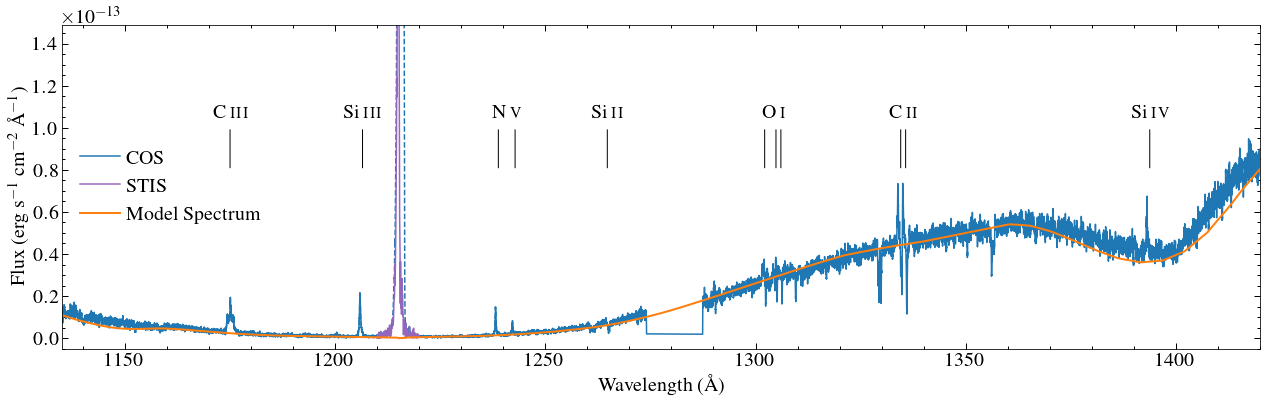

In [12]:
plt.figure(figsize=(18, 6))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask], c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask], c='C4', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(mw, mf, c='C1', lw=2, label= 'Model Spectrum')

si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775]#,1402.770]
o1 = [1302.17,1304.86,1306.03]
c2 = [1334.532, 1335.703]
c2i = [1175]
si3i = [1206.51]
nv = [1238.821,1242.804]

names = ['Si\,{\sc ii}', 'Si\,{\sc iv}', 'O\,{\sc i}', 'C\,{\sc ii}', 'C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}']
lines = [si2, si4, o1,c2, c2i, si3i, nv]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 0.8e-13), xytext=(line, 1.0e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
    plt.annotate(name,(np.mean(si), 1.e-13), xytext=(np.mean(si), 1.05e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

# plt.plot(gjw, gjf, c='C2')

plt.xlim(1135, 1420)
plt.ylim(-0.05e-13, 1.49e-13)
plt.legend(loc=6)

#add background
plt.plot(wc[wc <1250], fc[wc <1250], ls='--', zorder=-10)

plt.tight_layout()
# plt.xscale('log')
# plt.yscale('log')
plt.savefig('plots/eg_uma_fuv.pdf', dpi=150)


Can I fit the CII lines?

-149.74163933621804 km / s 1.2736709719691817 km / s 1.27367097196921 km / s
3.7063316310810244 km / s 2.7501241949364745 km / s 2.7501241948699073 km / s
65.32163894588234 km / s 0.8890630270017112 km / s 0.889063027001697 km / s


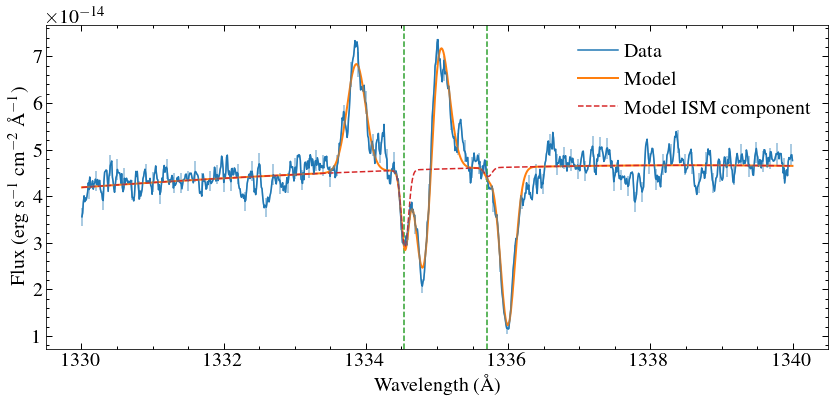

In [30]:
def tiedfunc0(gg_init):
    mean = gg_init.mean_1.value+1.171
    # mean = gg_init.mean_1.value+1.171
    return mean

def tiedfunc1(gg_init):
    mean = gg_init.mean_2.value+1.171
    return mean

def tiedfunc2(gg_init):
    mean = gg_init.mean_3.value+1.171
    return mean

plt.figure(figsize=(12,6))

fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)
c2 = [1334.532, 1335.703]
oss = [1.29e-01,  1.15e-01]
# print(np.diff(c2))

cmask = (wc > 1330) & (wc < 1340)
wline, fline, eline, =wc[cmask], fc[cmask], ec[cmask]
plt.plot(wline,fline, label ='Data')
plt.errorbar(wline, fline, yerr=eline, errorevery=10, alpha=0.5, c='C0')

models.Polynomial1D(2)
gg_init = models.Polynomial1D(2)
dv_guess = np.array([-150, -10, +70])*u.km/u.s
stds = [0.1, 0.05, 0.1]
amps =[2e-14, -1e-14, -2e-14]
for line in c2:
    for i, dv in enumerate(dv_guess):
        guess_line = dv.to(u.AA,  equivalencies=u.doppler_optical(line*u.AA)).value
        gg_init += models.Gaussian1D(amps[i], guess_line, stds[i])
        
        
        
def tiedfunc0(gg_init):
    mean = gg_init.mean_1.value+np.diff(c2)
    # mean = gg_init.mean_1.value+1.171
    return mean

def tiedfunc1(gg_init):
    mean = gg_init.mean_2.value+np.diff(c2)
    return mean

def tiedfunc2(gg_init):
    mean = gg_init.mean_3.value+np.diff(c2)
    return mean
        
        
gg_init.mean_4.tied=tiedfunc0
gg_init.mean_5.tied=tiedfunc1
gg_init.mean_6.tied=tiedfunc2


def tiedfunc3(gg_init):
    return gg_init.stddev_1.value
    
    
def tiedfunc4(gg_init):
    return gg_init.stddev_2.value

def tiedfunc5(gg_init):
    return gg_init.stddev_3.value
    
gg_init.stddev_4.tied=tiedfunc3 
gg_init.stddev_5.tied=tiedfunc4 
gg_init.stddev_6.tied=tiedfunc5 

def tiedfunc6(gg_init):
    return gg_init.amplitude_1.value*(oss[1]/oss[0])

def tiedfunc7(gg_init):
    return gg_init.amplitude_2.value*(oss[1]/oss[0])

def tiedfunc8(gg_init):
    return gg_init.amplitude_3.value*(oss[1]/oss[0])

# gg_init.amplitude_4.tied= tiedfunc6
# gg_init.amplitude_5.tied= tiedfunc7
# gg_init.amplitude_6.tied= tiedfunc8



gg_fit = fitter(gg_init, wline, fline, weights=1/eline, maxiter=100000)
[plt.axvline(line,ls='--', c='C2') for line in c2]



# dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
dvs = []
dves =[]
dveus = []
dvels = []
means = []

if type(fitter.fit_info['param_cov']) == np.ndarray:
#     print('hooray!')
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    # print(fit_e)
    epos = [4, 7,10, 12, 13, 14] #index of the mean errors in fit_e
    for i in range(3):
        mean, mean_e = gg_fit[i+1].mean, fit_e[epos[i]]
        dv = (mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        eup = ((mean+mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        edo = ((mean-mean_e)*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(c2[0]*u.AA))
        dve= np.mean([abs(dv-eup).value, abs(dv-edo).value])*u.km/u.s   
        # print(dv, dve)
        print(dv, dv-edo, eup-dv)
        dvs.append(dv)
        dveus.append(eup)
        dvels.append(edo)
        dves.append(dve)
        means.append(mean.value)
        

# [plt.axvline(m, ls='--', alpha=0.5, c='C3') for m in means]


ism_fit = gg_fit[0]+gg_fit[2]+gg_fit[5]

plt.plot(wline, gg_fit(wline), label='Model', lw=2)
plt.plot(wline, ism_fit(wline), c='C3', ls='--', label = 'Model ISM component')

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.tight_layout()



In [31]:
m1 = 0.514*u.Msun #Odette's result for the mass of the wd
m2 = 0.24*u.Msun #from Bleach et al 2000
v1 = dvs[2] #wd velocity
v2 = dvs[0] # rd velocity
e1 = dves[2]
e2 = dves[0]
print(e1, e2)
ve = abs(v1/v2)*((e1/v1)**2+(e2/v2)**2)**0.5
print('v1/v2', abs(v1/v2), ve)
# print('ve', ve)
print('m2/m1', m2/m1)

gamma = -29*u.km/u.s
ge = 4.8*u.km/u.s
gs = 22.7*u.km/u.s
ratio_adj = -1*((v1-gamma-gs)/(v2-gamma))
re = ratio_adj*((e1/v1)**2+(e2/v2)**2+(ge/gamma)**2)**0.5
print('v1/v2_adj', ratio_adj, re)

v1b = 81.7 #bleach
v1be = 6.6
v2b = 125.9
v2be= 0.4
vbe = abs(v1b/v2b)*((v1be/v1b)**2+(v2be/v2b)**2)**0.5
print('v1b/v2b', abs(v1b/v2b), vbe)

0.8890630270017041 km / s 1.2736709719691959 km / s
v1/v2 0.4362289556561772 0.0070013778358608515
m2/m1 0.46692607003891046
v1/v2_adj 0.5931809385695369 0.09864217796379553
v1b/v2b 0.6489277204130262 0.05246308464856771


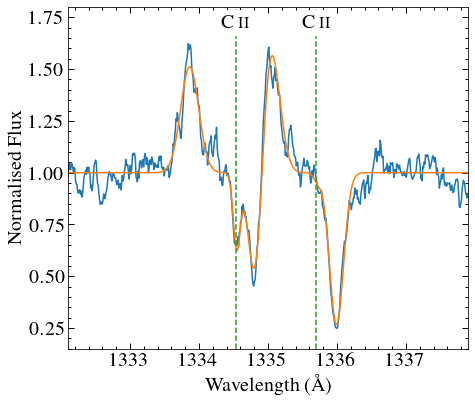

In [32]:
plt.figure(figsize=(7, 6))
plt.plot(wline,fline/gg_fit[0](wline))
plt.plot(wline, gg_fit(wline)/gg_fit[0](wline))
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Normalised Flux')
plt.xlim(1332.1, 1337.9)
plt.ylim(0.15, 1.8)
for line in c2:
    plt.annotate('C\,{\sc ii}',(line, 1.7), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
    plt.axvline(line, ls='--', c='C2')
plt.tight_layout()
plt.savefig('plots/c2_fit.pdf', dpi=150)

Adding the lines plot as an inset to the COS spectrum

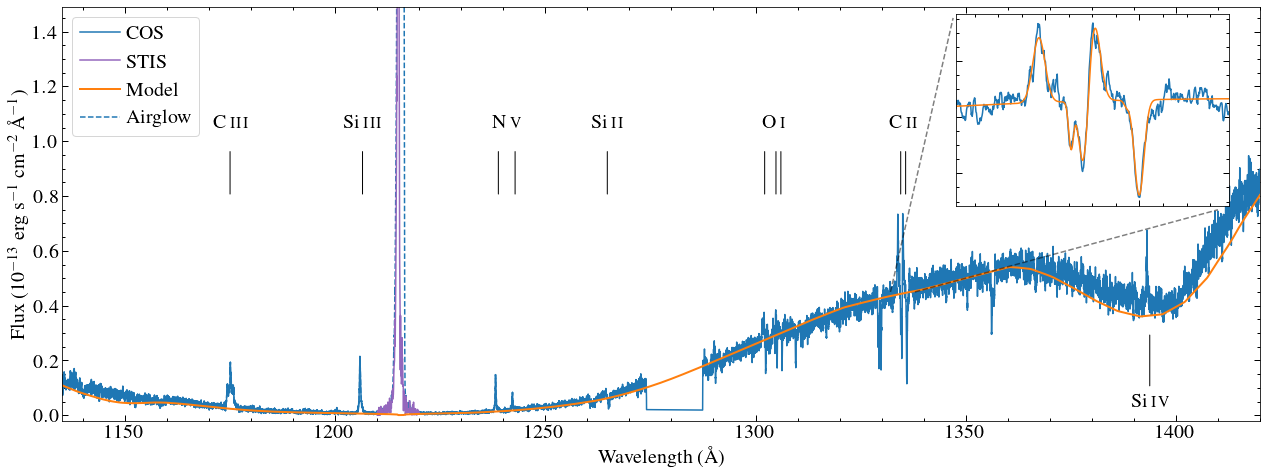

In [33]:
fscale= 1e13

fig, ax = plt.subplots(figsize=(18, 7))
mask = (wc < 1210) & (fc>0)
plt.plot(wc[mask], fc[mask]*fscale, c='C0')
mask = (wc > 1220) & (fc>0)
plt.plot(wc[mask], fc[mask]*fscale, c='C0', label='COS')
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask]*fscale, c='C4', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(mw, mf*fscale, c='C1', lw=2, label= 'Model')

si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775]#,1402.770]
o1 = [1302.17,1304.86,1306.03]
c2 = [1334.532, 1335.703]
c2i = [1175]
si3i = [1206.51]
nv = [1238.821,1242.804]

names = ['Si\,{\sc ii}', 'Si\,{\sc iv}', 'O\,{\sc i}', 'C\,{\sc ii}', 'C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}']
lines = [si2, si4, o1,c2, c2i, si3i, nv]
for name, si in zip(names, lines):
    [plt.annotate('',(line, 0.8), xytext=(line, 1.0),arrowprops=dict(arrowstyle='-'), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)) for line in si]
    plt.annotate(name,(np.mean(si), 1.e-13), xytext=(np.mean(si), 1.05), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

[plt.annotate('',(line, 0.1), xytext=(line, 0.3),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si4]
plt.annotate(names[1],(np.mean(si4), 0.06), xytext=(np.mean(si4), 0.03), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
  
    
# plt.plot(gjw, gjf, c='C2')

plt.xlim(1135, 1420)
plt.ylim(-0.02, 1.49)


#add background
plt.plot(wc[wc <1250], fc[wc <1250]*fscale, ls='--', zorder=-10, label = 'Airglow')

plt.legend(loc=2, frameon=True)
# axins = inset_axes(ax, width=1.3, height=0.9)

plt.plot([1332.1, 1347], [0.45, 1.45], ls='--', c='k', alpha =0.5)
plt.plot([1337.9, 1410], [0.45, 0.75], ls='--', c='k', alpha =0.5)
plt.tight_layout()



axins = inset_axes(ax,width="100%", height="100%",
                   bbox_to_anchor=(1350, 0.8, 65,0.7),
                   bbox_transform=ax.transData)
# axins.plot(wline,fline/gg_fit[0](wline))
# axins.plot(wline, gg_fit(wline)/gg_fit[0](wline))
axins.plot(wline,fline*fscale)
axins.plot(wline, gg_fit(wline)*fscale)
# axins.set_yticks(which='both', visible=False)
axins.axes.yaxis.set_ticklabels([])
axins.axes.xaxis.set_ticklabels([])

# plt.xlabel('Wavelength (\AA)')
# axins.set_ylabel('Normalised Flux')
axins.set_xlim(1332.1, 1337.9)
# axins.set_ylim(0.15, 1.8)
# for line in c2:
#     axins.annotate('C\,{\sc ii}',(line, 1.7), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))
#     axins.axvline(line, ls='--', c='C2')




# plt.xscale('log')
# plt.yscale('log')
plt.savefig('plots/eg_uma_fuv_inset.pdf', dpi=150)
plt.savefig('plots/eg_uma_fuv_inset.png', dpi=150, facecolor='w')

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


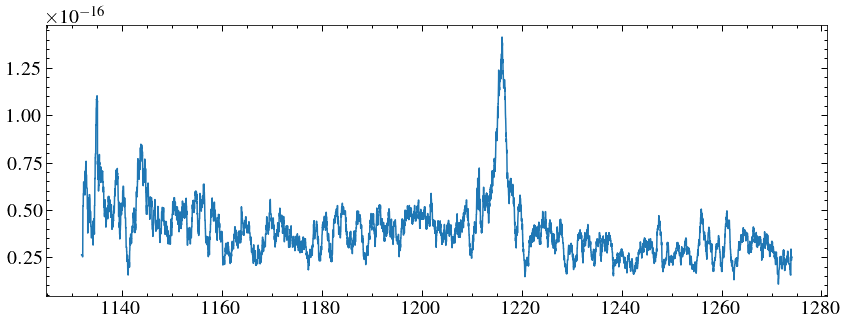

In [34]:
data = fits.getdata(x, 1)[1]
# plt.plot(data['WAVELENGTH'], data['GROSS']- (data['NET']+data['BACKGROUND']))
# plt.plot(data['WAVELENGTH'], data['NET']+data['BACKGROUND'])
# plt.plot(data['WAVELENGTH'], data['NET'])
# plt.plot(data['WAVELENGTH'], data['BACKGROUND'])
conv = data['FLUX']/data['NET']
# plt.plot(data['WAVELENGTH'], data['FLUX']/data['NET'])
# plt.plot(data['WAVELENGTH'], data['FLUX'])
plt.plot(data['WAVELENGTH'], data['BACKGROUND']*conv)

Make plot comparing FUV with Galex pass band. Not very helpful, need more FUV.

In [35]:
# plt.plot(wc, fc)
# gbw, gbp = np.loadtxt('/home/david/work/filters/galex/GALEX_GALEX.FUV.dat', unpack=True)
# plt.plot(gbw, gbp*1e-12)

20211201 apparently we have a Swift spectrum?

In [36]:
# ws, fs, es, dq = np.loadtxt('/media/david/1tb_storage1/emergency_data/eg_uma/swift/uvot/eguma_swift_grism.txt', unpack=True)

In [37]:
# # plt.plot(ws, fs)
# mask = (ws > 1700) & (dq == 0)
# plt.plot(ws[mask], fs[mask])
# plt.yscale('log')
# plt.plot(wc, fc)
# plt.plot(mw, mf)

Continum is beleaveable but I don't know what that feature at 1800 is. Ok theres a massive flag there, need to use the fits file. Nope not there, huh?

In [38]:
# #no mg lines - wd too bright?

# plt.plot(ws[mask], fs[mask])
# plt.xlim(2700, 3000)
# plt.ylim(0, 1e-13)


In [39]:
# plt.plot(ws[mask], fs[mask])
# plt.plot(wo, fo*2.7e11)
# plt.xlim(wo[0].value, wo[-1].value)
# # plt.ylim(0, 1e-13)
# plt.yscale('log')

# #low res?

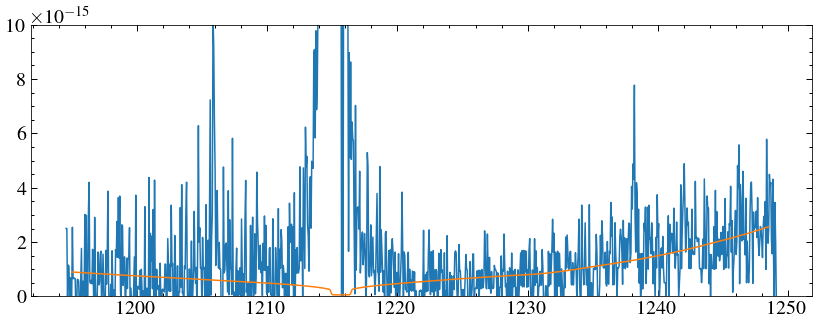

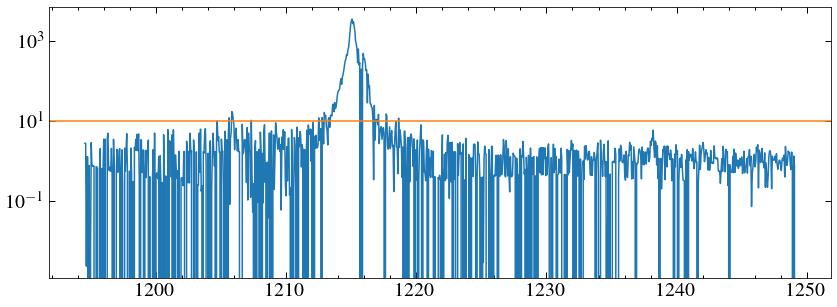

In [40]:
# plt.plot(mw, mf)
# plt.xlim(1205, 1225)
plt.ylim(0, 10e-15)
# mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws, fs)
# plt.plot(ws[mask], fs[mask], c='C4', label='STIS')
mask = (mw > ws[0]) & (mw < ws[-1])
plt.plot(mw[mask], mf[mask])
plt.show()
mi = interp1d(mw[mask], mf[mask], fill_value='extrapolate')(ws)
plt.plot(ws, fs/mi)
plt.yscale('log')
plt.axhline(10, c='C1')

(0.0, 5e-14)

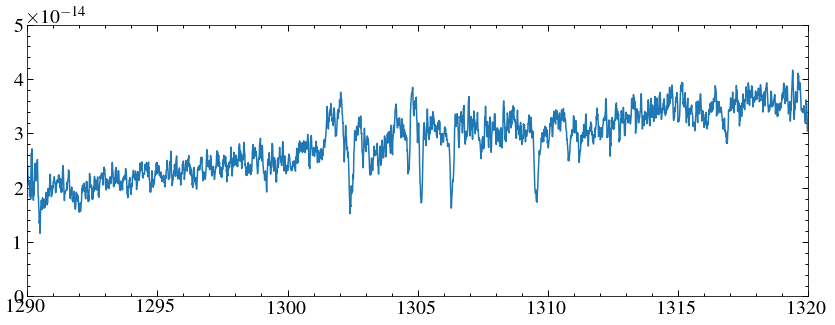

In [41]:
plt.plot(wc, fc)
plt.xlim(1290, 1320)
plt.ylim(0, 0.5e-13)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean              stddev      
    ----------------- ------------------ ------------------
    3.057251496921756 1.1753592763065543 0.8111779369476083
standard deviations
amplitude| 0.046
mean     | 0.014
stddev   | 0.014
[0.04633095 0.01419428 0.01419428]


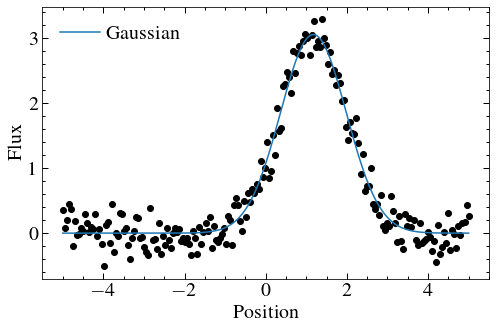

In [42]:

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.2)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)


# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.) 
fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True) #whaaaaaaaaaattttt!!!!
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)
print(g)
print(g.stds)
fit_e = np.sqrt(np.diag(fit_g.fit_info['param_cov']))
print(fit_e)
# print(fitter.fit_info)

In [43]:
#updated Md mass
kwd = 81.7
kmd = 124.7
mwd = 0.51

mrd = mwd*kwd/kmd
print(mrd)

0.33413793103448275


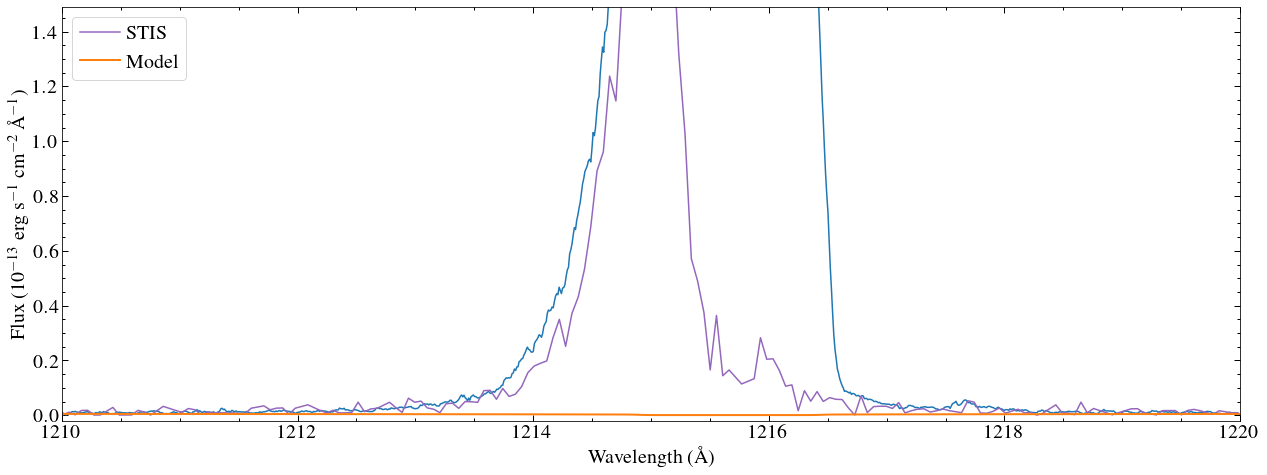

In [49]:
fscale= 1e13

fig, ax = plt.subplots(figsize=(18, 7))
# mask = (wc < 1210) & (fc>0)
# plt.plot(wc[mask], fc[mask]*fscale, c='C0')
# mask = (wc > 1216) & (fc>0)
# plt.plot(wc[mask], fc[mask]*fscale, c='C0', label='COS')
plt.plot(wc, fc*fscale)
mask = (ws > 1210) & (ws < 1220) & (fs>0)
plt.plot(ws[mask], fs[mask]*fscale, c='C4', label='STIS')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.plot(mw, mf*fscale, c='C1', lw=2, label= 'Model')

si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775]#,1402.770]
o1 = [1302.17,1304.86,1306.03]
c2 = [1334.532, 1335.703]
c2i = [1175]
si3i = [1206.51]
nv = [1238.821,1242.804]

# names = ['Si\,{\sc ii}', 'Si\,{\sc iv}', 'O\,{\sc i}', 'C\,{\sc ii}', 'C\,{\sc iii}', 'Si\,{\sc iii}', 'N\,{\sc v}']
# lines = [si2, si4, o1,c2, c2i, si3i, nv]
# for name, si in zip(names, lines):
#     [plt.annotate('',(line, 0.8), xytext=(line, 1.0),arrowprops=dict(arrowstyle='-'), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)) for line in si]
#     plt.annotate(name,(np.mean(si), 1.e-13), xytext=(np.mean(si), 1.05), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# plt.plot(gjw, gjf, c='C2')

plt.xlim(1210, 1220)
plt.ylim(-0.02, 1.49)


#add background
# plt.plot(wc[wc <1250], fc[wc <1250]*fscale, ls='--', zorder=-10, label = 'Airglow')

plt.legend(loc=2, frameon=True)
# axins = inset_axes(ax, width=1.3, height=0.9)

plt.tight_layout()




# plt.xscale('log')
# plt.yscale('log')
# plt.savefig('plots/eg_uma_fuv_inset.pdf', dpi=150)
# plt.savefig('plots/eg_uma_fuv_inset.png', dpi=150, facecolor='w')